# **Import Library & Dataset**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hnswlib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
events = pd.read_csv("events.csv")
item_prop1 = pd.read_csv("item_properties_part1.csv")
item_prop2 = pd.read_csv("item_properties_part2.csv")
category_tree = pd.read_csv("category_tree.csv")

In [3]:
events

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [4]:
item_prop1

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [5]:
item_prop2

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


In [6]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [7]:
item_props = pd.concat([item_prop1, item_prop2], axis=0)

# **Data Inspection**

In [8]:
events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [9]:
events.duplicated().sum()

np.int64(460)

In [10]:
events['event'].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [11]:
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
print(f"\nRentang waktu data: {events['timestamp'].min()} → {events['timestamp'].max()}")


Rentang waktu data: 2015-05-03 03:00:04.384000 → 2015-09-18 02:59:47.788000


In [12]:
events.shape

(2756101, 5)

In [13]:
item_props.shape

(20275902, 4)

# **EDA**

C:\Users\user\AppData\Local\Temp\ipykernel_8936\753278946.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=events, x='event', palette='pastel')


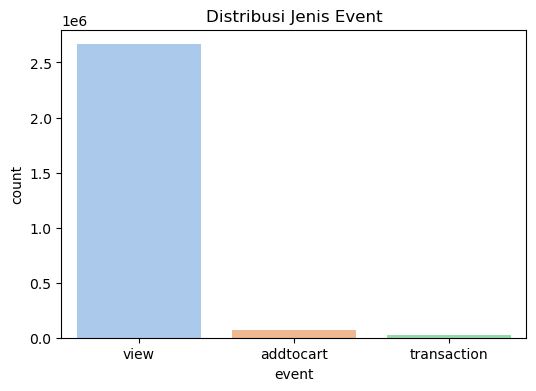

In [14]:
# Distribusi tipe event
plt.figure(figsize=(6,4))
sns.countplot(data=events, x='event', palette='pastel')
plt.title("Distribusi Jenis Event")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8936\1622346674.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.index, y=top_items.values, palette='viridis')


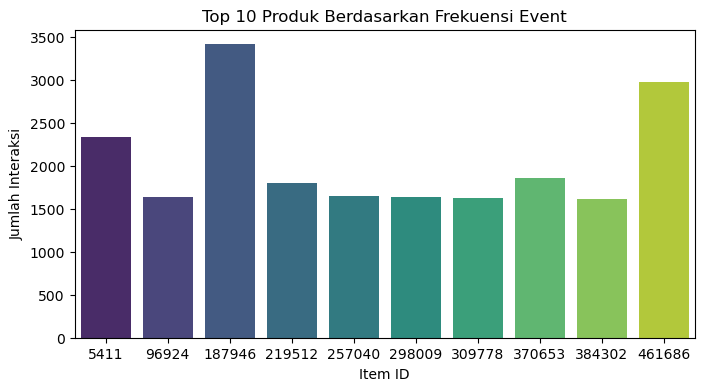

In [15]:
# Top 10 item paling sering dilihat/dibeli
top_items = events['itemid'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_items.index, y=top_items.values, palette='viridis')
plt.title("Top 10 Produk Berdasarkan Frekuensi Event")
plt.xlabel("Item ID")
plt.ylabel("Jumlah Interaksi")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8936\3496688921.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='mako')


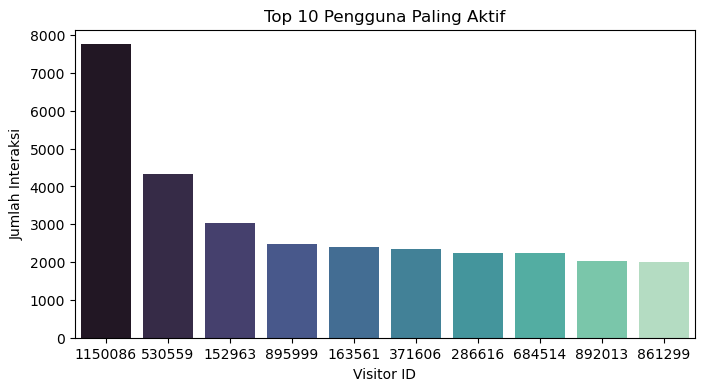

In [16]:
# Top 10 user paling aktif
top_users = events['visitorid'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='mako')
plt.title("Top 10 Pengguna Paling Aktif")
plt.xlabel("Visitor ID")
plt.ylabel("Jumlah Interaksi")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8936\731301441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette='coolwarm')


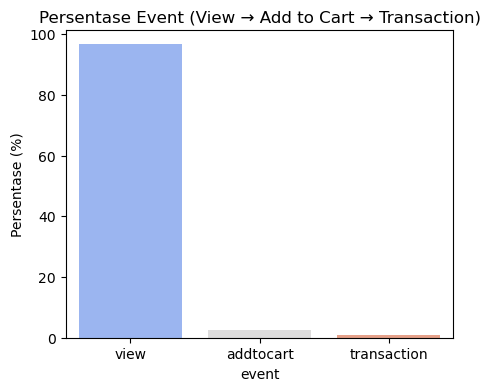

In [17]:
event_counts = events['event'].value_counts(normalize=True) * 100
plt.figure(figsize=(5,4))
sns.barplot(x=event_counts.index, y=event_counts.values, palette='coolwarm')
plt.title("Persentase Event (View → Add to Cart → Transaction)")
plt.ylabel("Persentase (%)")
plt.show()

# **Preprocessing**

In [18]:
events = events[events['event'].isin(['view', 'addtocart', 'transaction'])]

In [19]:
weight_map = {'view': 1, 'addtocart': 2, 'transaction': 3}
events['weight'] = events['event'].map(weight_map)

In [20]:
np.random.seed(42)
sample_items = np.random.choice(events['itemid'].unique(), size=5000, replace=False)
events = events[events['itemid'].isin(sample_items)]

In [21]:
print("Unique users:", events['visitorid'].nunique())
print("Unique items:", events['itemid'].nunique())

Unique users: 40831
Unique items: 5000


# **Collaborative Filtering Using Cosine Similarity**

In [22]:
user_item_matrix = events.pivot_table(
    index='visitorid',
    columns='itemid',
    values='weight',
    aggfunc='sum'
).fillna(0)

print("User–Item Matrix Shape:", user_item_matrix.shape)

User–Item Matrix Shape: (40831, 5000)


In [23]:
user_sim_df = pd.DataFrame(
    cosine_similarity(user_item_matrix),
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

In [24]:
def recommend_items(user_id, top_n=5):
    """Rekomendasi berdasarkan user mirip"""
    if user_id not in user_sim_df.index:
        return []
    similar_users = user_sim_df[user_id].sort_values(ascending=False).index[1:6]
    similar_users_items = user_item_matrix.loc[similar_users].sum(axis=0)
    unseen_items = similar_users_items[user_item_matrix.loc[user_id] == 0]
    return unseen_items.sort_values(ascending=False).head(top_n).index.tolist()

In [25]:
example_user = user_item_matrix.index[0]
recommendations = recommend_items(example_user, top_n=5)
print(f"Rekomendasi untuk user {example_user}: {recommendations}")

Rekomendasi untuk user 54: [466845, 6, 117, 256, 312]


In [26]:
user_id = 54
user_data = events[events['visitorid'] == user_id]
print(user_data)

                      timestamp  visitorid event  itemid  transactionid  \
1440443 2015-09-15 17:39:08.248         54  view   38965            NaN   
1458055 2015-09-18 01:03:27.379         54  view   38965            NaN   

         weight  
1440443       1  
1458055       1  


In [27]:
user_counts = events['visitorid'].value_counts()
active_users = user_counts[user_counts > 10].index  # minimal 10 interaksi
print(active_users[:10])

Index([1348163, 1150086,  530559,  371606, 1297062,  163561,  152963,  850978,
        892013,   26633],
      dtype='int64', name='visitorid')


In [28]:
recommend_for = active_users[0]

In [29]:
target_user = 1348163

In [30]:
user_data = events[events['visitorid'] == target_user]
print(user_data['event'].value_counts())
print(user_data.head())

event
view    173
Name: count, dtype: int64
                     timestamp  visitorid event  itemid  transactionid  weight
62796  2015-06-03 17:09:23.518    1348163  view  191049            NaN       1
83783  2015-06-04 17:35:43.585    1348163  view  191049            NaN       1
91547  2015-06-04 08:16:12.072    1348163  view  191049            NaN       1
96247  2015-06-05 21:44:33.346    1348163  view  191049            NaN       1
111122 2015-06-05 07:02:09.541    1348163  view  191049            NaN       1


In [31]:
user_sim_matrix = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim_matrix, 
                           index=user_item_matrix.index, 
                           columns=user_item_matrix.index)

In [32]:
def recommend_items(user_id, top_n=5):
    if user_id not in user_sim_df.index:
        return []

    # cari user paling mirip
    similar_users = user_sim_df[user_id].sort_values(ascending=False).index[1:6]
    
    # ambil item yang sudah diinteraksikan oleh user mirip
    similar_users_items = user_item_matrix.loc[similar_users].sum(axis=0)
    
    # item yang belum pernah dilihat user ini
    items_seen = user_item_matrix.loc[user_id]
    unseen_items = similar_users_items[items_seen == 0]
    
    # rekomendasi top N item
    recommendations = unseen_items.sort_values(ascending=False).head(top_n).index.tolist()
    return recommendations

In [33]:
recommended_items = recommend_items(target_user, top_n=5)
print(f"Rekomendasi untuk user {target_user}: {recommended_items}")

Rekomendasi untuk user 1348163: [466845, 6, 117, 256, 312]


# **Content Based Filtering Using HNSW**

In [34]:
valid_items = set(events['itemid'].unique()) & set(item_props['itemid'].unique())

In [35]:
# Filter dataset events dan item_props agar hanya berisi item valid
events = events[events['itemid'].isin(valid_items)]
item_props = item_props[item_props['itemid'].isin(valid_items)]

print(f"Total item setelah sinkronisasi: {len(valid_items)}")

Total item setelah sinkronisasi: 3983


In [36]:
item_categories = item_props[item_props['property'] == 'categoryid'][['itemid', 'value']]
item_categories.rename(columns={'value': 'categoryid'}, inplace=True)

item_categories['categoryid'] = item_categories['categoryid'].astype(int)

In [37]:
item_categories = item_categories.drop_duplicates(subset='itemid')

In [38]:
item_features = pd.get_dummies(item_categories.set_index('itemid')['categoryid'])

print(f"Dimensi item_features: {item_features.shape}")

Dimensi item_features: (3983, 649)


In [39]:
category_tree = category_tree.copy()

# Isi NaN parentid dengan 0 terlebih dahulu
category_tree['parentid'] = category_tree['parentid'].fillna(0)

In [40]:
category_tree = category_tree.copy()
category_tree['categoryid'] = category_tree['categoryid'].astype(int)
category_tree['parentid'] = category_tree['parentid'].astype(int)

In [41]:
parent_map = dict(zip(category_tree['categoryid'], category_tree['parentid']))

In [42]:
def get_all_parents(cat_id, parent_map):
    parents = []
    visited = set()
    while cat_id in parent_map and parent_map[cat_id] != 0 and cat_id not in visited:
        visited.add(cat_id)
        cat_id = parent_map[cat_id]
        parents.append(cat_id)
    return parents

In [43]:
expanded_rows = []
for _, row in item_categories.iterrows():
    parents = get_all_parents(row['categoryid'], parent_map)
    for p in parents:
        expanded_rows.append({'itemid': row['itemid'], 'categoryid': p})

In [44]:
expanded_df = pd.concat([item_categories, pd.DataFrame(expanded_rows)], ignore_index=True).drop_duplicates()

print(f"Jumlah kategori unik sebelum ekspansi: {item_categories['categoryid'].nunique()}")
print(f"Jumlah kategori unik setelah ekspansi: {expanded_df['categoryid'].nunique()}")

Jumlah kategori unik sebelum ekspansi: 649
Jumlah kategori unik setelah ekspansi: 895


In [45]:
item_features = pd.get_dummies(expanded_df.set_index('itemid')['categoryid'])
item_features = item_features.groupby('itemid').max()  # kalau ada duplikat kategori
print(f"Bentuk fitur item: {item_features.shape}")

Bentuk fitur item: (3983, 895)


In [46]:
data = item_features.values.astype('float32')
ids = np.arange(data.shape[0])

dim = data.shape[1]
num_elements = data.shape[0]

In [47]:
index = hnswlib.Index(space='cosine', dim=dim)
index.init_index(max_elements=num_elements, ef_construction=200, M=64)
index.add_items(data, ids)
index.set_ef(50)


In [48]:
print(f"HNSW index berhasil dibangun untuk {num_elements} item (dimensi: {dim})")

HNSW index berhasil dibangun untuk 3983 item (dimensi: 895)


In [49]:
index = hnswlib.Index(space='cosine', dim=dim)
index.init_index(max_elements=num_elements, ef_construction=200, M=64)
index.add_items(data, ids)
index.set_ef(50)

print(f"HNSW index dibangun untuk {num_elements} item, dimensi: {dim}")

HNSW index dibangun untuk 3983 item, dimensi: 895


In [50]:
def get_similar_items(item_id, top_n=5):
    if item_id not in item_features.index:
        return "Item tidak ditemukan."

    item_idx = item_features.index.get_loc(item_id)
    labels, distances = index.knn_query(data[item_idx], k=top_n + 1)  # +1 untuk item itu sendiri
    
    similar_indices = labels[0][1:]  # skip item itu sendiri
    similar_items = item_features.index[similar_indices]
    return list(similar_items)

In [51]:
example_item = item_features.index[0]
print(f"Rekomendasi item mirip untuk {example_item}:")
print(get_similar_items(example_item, top_n=5))

Rekomendasi item mirip untuk 6:
[56944, 140284, 144466, 417786, 457184]


# **Hybrid Recommender System**

In [52]:
def hybrid_recommendation(user_id, top_n=5, min_interactions=3):
    """
    Hybrid Recommendation:
    - Jika user memiliki cukup interaksi (>= min_interactions) → Collaborative Filtering
    - Jika user baru / sedikit interaksi → Content-Based Filtering (HNSW)
    """

    # --- 1️⃣ Cek apakah user ada dalam data
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} tidak ditemukan dalam dataset.")
        return []

    # --- 2️⃣ Ambil interaksi user
    user_interactions = user_item_matrix.loc[user_id]
    interacted_items = user_interactions[user_interactions > 0].index.tolist()

    # --- 3️⃣ Tentukan metode berdasarkan jumlah interaksi
    if len(interacted_items) >= min_interactions:
        # ===========================
        # COLLABORATIVE FILTERING
        # ===========================
        similar_users = user_sim_df[user_id].sort_values(ascending=False).index[1:6]
        similar_users_items = user_item_matrix.loc[similar_users].sum(axis=0)
        unseen_items = similar_users_items[user_item_matrix.loc[user_id] == 0]
        rec_items = unseen_items.sort_values(ascending=False).head(top_n).index.tolist()
        method = "Collaborative Filtering"
    
    else:
        # ===========================
        # CONTENT-BASED FILTERING (HNSW)
        # ===========================
        if len(interacted_items) > 0:
            last_item = interacted_items[-1]
        else:
            # Jika user belum pernah interaksi sama sekali, pilih item random
            last_item = np.random.choice(item_features.index)
        
        rec_items = get_similar_items(last_item, top_n=top_n)
        method = "Content-Based (HNSW)"

    # --- 4️⃣ Hasil rekomendasi
    print(f"\n🔹 Metode yang digunakan: {method}")
    print(f"🔹 User ID: {user_id}")
    print(f"🔹 Item yang direkomendasikan: {rec_items}")
    return rec_items

In [53]:
target_user = 54
hybrid_recommendation(target_user, top_n=10)


🔹 Metode yang digunakan: Content-Based (HNSW)
🔹 User ID: 54
🔹 Item yang direkomendasikan: [82831, 136815, 137266, 428420, 449962, 26634, 53698, 97722, 163076, 432435]


[82831, 136815, 137266, 428420, 449962, 26634, 53698, 97722, 163076, 432435]

# **Optimize Hybrid Recommender System**

In [54]:
def get_similar_items(item_id, top_n=5):
    if item_id not in item_features.index:
        return []  # hindari error, return kosong

    item_idx = item_features.index.get_loc(item_id)
    labels, distances = index.knn_query(data[item_idx], k=top_n + 1)  # +1 = item itu sendiri
    
    similar_indices = labels[0][1:]  # lewati item itu sendiri
    similar_items = item_features.index[similar_indices]
    return list(similar_items)

In [55]:
def hybrid_recommend(user_id, top_n=5):
    # CASE A: jika user ada dalam collaborative filtering
    if user_id in user_item_matrix.index:
        print(f"\n🔹 Metode yang digunakan: Collaborative Filtering")
        recommended_items = recommend_items(user_id, top_n=top_n)
        return recommended_items
    
    # CASE B: fallback → content-based
    else:
        print(f"\n🔹 Metode yang digunakan: Content-Based (HNSW)")
        
        # Coba cari item terakhir yang pernah dilihat user ini
        user_data = events[events['visitorid'] == user_id]
        if user_data.empty:
            # kalau user benar-benar baru, ambil item random
            random_item = np.random.choice(item_features.index)
            return get_similar_items(random_item, top_n)
        
        last_item = user_data.iloc[-1]['itemid']
        return get_similar_items(last_item, top_n)

In [57]:
test_users = [1348163, 460429, 54, 6]

for uid in test_users:
    recs = hybrid_recommend(uid, top_n=5)
    print(f"🔹 User ID: {uid}")
    print(f"🔹 Item yang direkomendasikan: {recs}\n")


🔹 Metode yang digunakan: Collaborative Filtering
🔹 User ID: 1348163
🔹 Item yang direkomendasikan: [466845, 6, 117, 256, 312]


🔹 Metode yang digunakan: Content-Based (HNSW)
🔹 User ID: 460429
🔹 Item yang direkomendasikan: [240171, 344142, 351384, 373629, 430738]


🔹 Metode yang digunakan: Collaborative Filtering
🔹 User ID: 54
🔹 Item yang direkomendasikan: [466845, 6, 117, 256, 312]


🔹 Metode yang digunakan: Content-Based (HNSW)
🔹 User ID: 6
🔹 Item yang direkomendasikan: [92712, 164781, 235337, 338972, 418264]



# **Hybrid Weighting Recommender System**

In [ ]:
def hybrid_weighted_recommend(user_id, top_n=5, alpha=0.7):
    """
    Menggabungkan Collaborative Filtering + Content-Based (HNSW)
    dengan bobot alpha.
    
    alpha → bobot CF (0–1)
    (1-alpha) → bobot Content-Based
    """
    # --- 1️⃣ Cek apakah user ada di user-item matrix
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} tidak ditemukan di data CF.")
        return []

    # --- 2️⃣ Ambil interaksi user & item yang sudah dilihat
    user_vector = user_item_matrix.loc[user_id]
    interacted_items = user_vector[user_vector > 0].index.tolist()

    if len(interacted_items) == 0:
        print(f"User {user_id} belum memiliki interaksi.")
        # fallback → pilih item random lalu gunakan HNSW
        random_item = np.random.choice(item_features.index)
        return get_similar_items(random_item, top_n=top_n)

    # --- 3️⃣ (CF) Prediksi skor dari user-user similarity
    similar_users = user_sim_df[user_id].sort_values(ascending=False).index[1:11]
    cf_scores = user_item_matrix.loc[similar_users].sum(axis=0)

    # --- 4️⃣ (Content-Based) Prediksi skor dari item terakhir
    last_item = interacted_items[-1]
    if last_item in item_features.index:
        labels, distances = index.knn_query(
            data[item_features.index.get_loc(last_item)], k=len(item_features)
        )
        cb_scores = 1 - distances[0]  # ubah jarak → skor kemiripan
        cb_items = item_features.index[labels[0]]
        cb_score_series = pd.Series(cb_scores, index=cb_items)
    else:
        cb_score_series = pd.Series(0, index=item_features.index)

    # --- 5️⃣ Normalisasi kedua skor (biar skala setara)
    scaler = MinMaxScaler()
    cf_scores_scaled = pd.Series(
        scaler.fit_transform(cf_scores.values.reshape(-1, 1)).flatten(),
        index=cf_scores.index
    )
    cb_scores_scaled = pd.Series(
        scaler.fit_transform(cb_score_series.values.reshape(-1, 1)).flatten(),
        index=cb_score_series.index
    )

    # --- 6️⃣ Gabungkan skor dengan bobot alpha
    hybrid_scores = alpha * cf_scores_scaled.add(
        (1 - alpha) * cb_scores_scaled, fill_value=0
    )

    # --- 7️⃣ Hapus item yang sudah pernah dilihat user
    hybrid_scores = hybrid_scores[~hybrid_scores.index.isin(interacted_items)]

    # --- 8️⃣ Ambil top N item
    recommended_items = hybrid_scores.sort_values(ascending=False).head(top_n).index.tolist()

    # --- 9️⃣ Output
    print(f"\n🔹 Metode: Hybrid Weighting (α={alpha})")
    print(f"🔹 User ID: {user_id}")
    print(f"🔹 Item direkomendasikan: {recommended_items}")

    return recommended_items